# September Sea Ice Extent Prediction

_Following the paper (Zhan et al., 2017)_, based on the relationship between June TOA-RSR (from both satellite products (i.e., CERES, and MISR) and reanalysis datasets (i.e., MERRA2)) and September SIE (from NSIDC Sea Ice Index, Version 3).

## 0. Preset

### 0.1 Load Modules

In [1]:
# modules used to process CERES data
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from netCDF4 import Dataset
from zyz_main import arc_ocean_mask, detnd
from scipy.stats import linregress
from tqdm import tqdm

# or inline
%matplotlib inline


In [1]:
from my_module import np, plt, tqdm, Dataset
from my_module.stat.comm import sm, detnd, linregress
from my_module.data.comm import arc_ocean_mask

### 0.2 Load Functions

In [69]:
# function used to calculate area-weighted Arctic mean value
# Write this function because different datasets may have different shapes. This function then serves as an universal function.
def area_weighted_mean(data, lat):
    """
    data should be a 2-D array while lat should be a 1-D array, and they should share the same first dimension.
    """
    lat_mean_data = np.nanmean(data, axis=1)
    lat_new = []
    for ilat, idata in zip(lat, lat_mean_data):
        if np.isnan(idata) == False:
            lat_new.append(ilat)
        else:
            lat_new.append(np.nan)
    area_mean = np.nansum(lat_mean_data*np.cos(np.deg2rad(lat))) / np.nansum(np.cos(np.deg2rad(lat)))
    
    return area_mean

# functions used to process CERES Level-3 data
def CERES_LV3_grid(dset, fld_name, year, month, version=4.0):
    ceres_dir = "/u/sciteam/smzyz/data/Satellite/EOS_TERRA/CERES"
    
    if dset == 'ebaf_toa':
        if version == 4.0:
            ncfile = ceres_dir + "/EBAF/CERES_EBAF-TOA_Ed4.0_Subset_200003-201707.nc"
        elif version == 2.8:
            ncfile = ceres_dir + "/EBAF/CERES_EBAF-TOA_Ed2.8_Subset_200003-201702.nc"
    elif dset == 'ebaf_sfc':
        if version == 4.0:
            ncfile = ceres_dir + "/EBAF/CERES_EBAF-Surface_Ed4.0_Subset_200003-201701.nc"
        elif version == 2.8:
            ncfile = ceres_dir + "/EBAF/CERES_EBAF-Surface_Ed2.8_Subset_200003-201702.nc"
    elif dset == 'ssf1deg':
        ncfile = ceres_dir + "/SSF1deg/monthly/CERES_SSF1deg-Month_Terra-MODIS_Ed4A_Subset_{}03-{}12.nc".format(year, year)
    else:
        print "Wrong dataset ..."
        return
    
    ncdf = Dataset(ncfile)
    fld = ncdf.variables[fld_name][:]
    
    if dset == 'ssf1deg':
        idx = month-3
    else:
        idx = (year-2000)*12 + (month-3)
        
    if (idx < 0) or (idx >= len(fld)): 
        print "Your selected time <{}.{}> is out of the time boundary, please choose a time within {}..."\
                    .format(year, month, ncfile.split('_')[-1][:-3])
        out_data = np.nan
    else:
        out_data = fld[idx]
    
    return out_data


def CERES_LV3_Arctic_mean(dset, fld_name, year, month, ocean_mask, version=4.0):
    m = arc_ocean_mask('CERES')
    
    lat = np.arange(70, 90) + 0.5
    try:
        fld = CERES_LV3_grid(dset, fld_name, year, month, version)[-20:, :]
    except:
        return
    
    if ocean_mask:
        fld_ocean = np.ma.masked_array(fld, mask=m.mask)
    else:
        fld_ocean = fld

    arc_mean = area_weighted_mean(fld_ocean, lat)

    return arc_mean

# functions used to process MISR CGAL data
def MISR_LV3_grid(dset, fld_name, year, month):
    """
    -------------
    | MISR-Arctic area grid data|
    -------------
    """
    misr_dir = "/u/sciteam/smzyz/data/Satellite/EOS_TERRA/MISR"

    if dset == 'CGAL':
        ncfile = misr_dir + "/CGAL/{0}/MISR_AM1_CGAL_1_DEG_F04_0024_{0}_{1}".format(year, str(month).zfill(2))    
    elif dset == 'CGAL':
        ncfile = misr_dir + "/CGCL/{0}/MISR_AM1_CGCL_0_5_DEG_F04_0024_{0}_{1}".format(year, str(month).zfill(2))  
    else:
        print "Wrong dataset ..."
        return
    
    ncdf = Dataset(ncfile)
    data = ncdf.variables[fld_name][:]
#     print "Retrieve \"{}\" from MISR \"{}\" dataset successfully, data shape in {}.".format(fld_name, dset, data.shape)
    
    return np.array(data)

def MISR_LV3_Arctic_mean_TOA_alb_RSR(alb_type, alb_band, year, month, ocean_mask, output='toa_rsr'):
    """
    alb_type could be 'Restrictive_albedo_average', 'Expansive_albedo_average' or 'Local_albedo_average';
    alb_band could be 0: blue, 1: green, 2: red, 3: NIR, or 4: broadband.
    """
    m = arc_ocean_mask('MISR')
    
    lat = np.arange(70, 90) + 0.5
    if alb_type in ['Restrictive_albedo_average', 'Expansive_albedo_average', 'Local_albedo_average']:
        alb = MISR_LV3_grid("CGAL", alb_type, year, month)[alb_band][0][-20:]
        insol_name = "{}_albedo_solar_insolation".format(alb_type.split('_')[0])
        sol = MISR_LV3_grid("CGAL", insol_name, year, month)[alb_band][0][-20:]
        
        if ocean_mask:
            # use ocean mask
            alb = np.ma.masked_array(alb, mask=m.mask)
            alb = np.ma.masked_equal(alb, -9999.0)
            sol = np.ma.masked_array(sol, mask=m.mask)
            sol = np.ma.masked_equal(sol, -9999.0)
        else:
            alb = np.ma.masked_equal(alb, -9999.0) 
            sol = np.ma.masked_equal(sol, -9999.0) 
            
        rsr = alb * sol
        arc_rsr = area_weighted_mean(rsr, lat)
        
        if output == 'toa_rsr':
            arc_mean = arc_rsr
        elif output == 'toa_alb':
            arc_mean = arc_rsr / area_weighted_mean(sol, lat)
            
    else:
        arc_mean = np.nan
    
    return arc_mean

# functions used to process NSIDC Sea Ice Index (V3.0) data
def NSIDC_SeaIceIndex_month(imon):
    '''
    Referred to G02135 dataset (V3.0).
    39-year monthly values between 1979 and 2016.
    '''
    file_path = "/u/sciteam/smzyz/data/Satellite/NSIDC/G02135/N_{}_area.txt".format(str(imon).zfill(2))
    f = open(file_path, 'r')
    data = f.readlines()
    
    sie = [float(iline.split(',')[4]) for iline in data]
    sie = np.ma.masked_values(sie, -9999.)
    
    return sie

In [59]:
# MISR_LV3_Arctic_mean_TOA_alb_RSR('Restrictive_albedo_average', 0, 2010, 6, True, output='toa_alb')

## 1.1 Time series of deseasonalized monthly anomalies of SIE and TOA-RSR

### 1.1.1 Data processing

In [18]:
# compute Arctic mean toa_rsr from EBAF dataset
idset = 'ebaf_toa'
ifld = 'toa_sw_all_mon'

toa_rsr = []
for iyr in tqdm(range(2000, 2017), mininterval=1):
    if iyr == 2000:
        mons = range(3, 13)
#     elif iyr == 2017:
#         mons = range(1, 8)
    else:
        mons = range(1, 13)
        
    for imon in mons:
        toa_rsr.append( CERES_LV3_Arctic_mean(idset, ifld, iyr, imon, ocean_mask=True, version=4.0))

toa_rsr = np.array(toa_rsr)

# complete 2000--2016 toa_rsr
toa_rsr_new = np.append([np.nan]*2, toa_rsr)
# toa_rsr_new = np.append(toa_rsr_new, [np.nan]*5)

# calculate deseasonalized monthly anomalies
toa_rsr_new = toa_rsr_new.reshape(17, 12)
toa_rsr_all = np.array([toa_rsr_new[:, i] - np.nanmean(toa_rsr_new[:, i]) for i in range(12)])
toa_rsr_all = toa_rsr_all.ravel(order='F')

# assign deseasonalized June TOA-RSR anomalies
toa_rsr_June = [np.nan]*204
for i in range(17):
    toa_rsr_June[i*12+5] = toa_rsr_all[i*12+5]

100%|██████████| 17/17 [00:49<00:00,  2.93s/it]


In [19]:
# read Arctic sea ice index from NSIDC G02135
sie = []
for imon in range(1, 13):
    if imon == 12:
        sie_data = NSIDC_SeaIceIndex_month(imon)[-17:]
    else:
        sie_data = NSIDC_SeaIceIndex_month(imon)[-18:-1]
    sie.append(sie_data - np.nanmean(sie_data))

# complete 18-year sie
sie_new = np.array(sie)

# calculate deseasonalized monthly anomalies
sie_all = sie_new.ravel(order='F')

# assign deseasonalized June TOA-RSR anomalies
sie_September = [np.nan]*204
for i in range(17):
    sie_September[i*12+8] = sie_all[i*12+8]

### 1.1.2 Figure plot

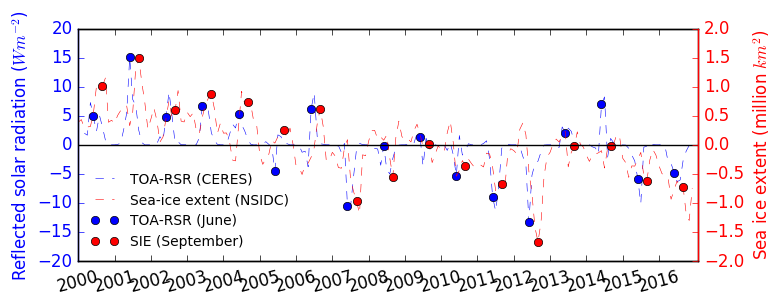

In [20]:

fig = plt.figure(figsize=(8, 3))
plt.matplotlib.rcParams.update({'font.size': 12})
ax = fig.add_subplot(111)

# CERES RSR time-series
lns1 = ax.plot(toa_rsr_all, 'b--', label='TOA-RSR (CERES)', linewidth=.4, markersize=12)
lns2 = ax.plot(toa_rsr_June, 'bo', label='TOA-RSR (June)')
ax.spines['left'].set_color('blue')
ax.tick_params(axis='y', colors='blue')
ax.yaxis.label.set_color('blue')
ax.set_ylim(-20, 20)
ax.set_xlim(0., 204.)
plt.xticks(range(0, 204, 12), range(2000, 2017), rotation=15)
plt.ylabel('Reflected solar radiation ($Wm^{-2}$)')

# NSIDC SIE time-series
ax2 = ax.twinx()
lns3 = ax2.plot(sie_all, 'r--', label='Sea-ice extent (NSIDC)', linewidth=.4, markersize=12)
lns4 = ax2.plot(sie_September, 'ro', label='SIE (September)')
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.plot([0, 205], [0, 0], 'k-')
ax2.set_ylim(-2.0, 2.0)
#minorticks_on()
ax2.yaxis.label.set_color('red')
plt.ylabel('Sea ice extent (million $km^2$)')

# Set legend
lns = lns1+lns3+lns2+lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=3, ncol=1, fontsize='small', frameon=False)
plt.show()

## 1.2 Relationship between detrended June reected solar radiation and September sea-ice extent

### 1.2.1 Data processing

In [102]:
# compute Arctic mean toa_jrsr from EBAF dataset
idset = 'ebaf_toa'
ifld = 'toa_sw_all_mon'
imon = 6
toa_jrsr = []
toa_jrsr_m = []
for iyr in range(2000, 2017):
    toa_jrsr.append( CERES_LV3_Arctic_mean(idset, ifld, iyr, imon, ocean_mask=True, version=4.0))
    toa_jrsr_m.append( MISR_LV3_Arctic_mean_TOA_alb_RSR('Restrictive_albedo_average', 4, iyr, imon, \
                                                        True, output='toa_rsr'))

jrsr_2000_2016 = np.array(toa_jrsr)
jrsr_m_2000_2016 = np.array(toa_jrsr_m)

# read Arctic September sea ice index from NSIDC G02135
ssie_2000_2016 = NSIDC_SeaIceIndex_month(9)[-18:-1]

detnd_jrsr_2000_2016 = detnd(jrsr_2000_2016, 1)[0]
detnd_jrsr_m_2000_2016 = detnd(jrsr_m_2000_2016, 1)[0]
detnd_ssie_2000_2016 = detnd(ssie_2000_2016, 1)[0]

# print some statistical results
X = sm.add_constant(detnd_jrsr_2000_2016)
res_ols = sm.OLS(detnd_ssie_2000_2016, X).fit()
res_ols.summary()

# X = sm.add_constant(detnd_jrsr_m_2000_2016)
# res_ols = sm.OLS(detnd_ssie_2000_2016, X).fit()
# res_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     59.99
Date:                Mon, 18 Dec 2017   Prob (F-statistic):           1.28e-06
Time:                        13:10:58   Log-Likelihood:                0.48592
No. Observations:                  17   AIC:                             3.028
Df Residuals:                      15   BIC:                             4.695
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -7.085e-15      0.061  -1.17e-13      1.000        -0.129     0.129
x1             0.0767      0.010      7.745      0.000         0.056     0.098
==============================================================================
Omnibus:                        1.895   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.388   Jarque-Bera (JB):                1.012
Skew:                          -0.597   Prob(JB):                        0.603
Kurtosis:                       2.968   Cond. No.                         6.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [103]:
X = sm.add_constant(detnd_jrsr_m_2000_2016)
res_ols = sm.OLS(detnd_ssie_2000_2016, X).fit()
res_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     35.38
Date:                Mon, 18 Dec 2017   Prob (F-statistic):           2.67e-05
Time:                        13:10:58   Log-Likelihood:                -2.8949
No. Observations:                  17   AIC:                             9.790
Df Residuals:                      15   BIC:                             11.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       1.166e-15      0.074   1.57e-14      1.000        -0.158     0.158
x1             0.0770      0.013      5.948      0.000         0.049     0.105
==============================================================================
Omnibus:                        3.247   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.197   Jarque-Bera (JB):                1.647
Skew:                           0.748   Prob(JB):                        0.439
Kurtosis:                       3.298   Cond. No.                         5.72
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 1.2.2 Figure plot

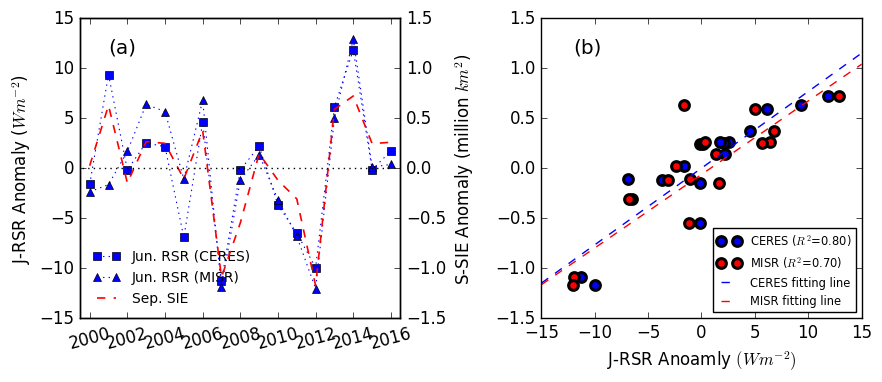

In [101]:
fig = plt.figure(figsize=(9, 4))

# 时间序列图 (Fig. 3a)
ax = fig.add_subplot(121)
# detnd_jrsr_2000_2016[1] = np.nan
# detnd_misr[1] = nan
lns1 = ax.plot(detnd_jrsr_2000_2016, 'bs:', label='Jun. RSR (CERES)', linewidth=0.8, markersize=6)
lns2 = ax.plot(detnd_jrsr_m_2000_2016, 'b^:', label='Jun. RSR (MISR)', linewidth=0.8, markersize=6)
plt.ylabel('J-RSR Anomaly ($Wm^{-2}$)')
plt.ylim(-15, 15)
plt.xticks(range(0, 17, 2), range(2000, 2017, 2), rotation=15)
ax1 = plt.twinx()
lns3 = ax1.plot(detnd_ssie_2000_2016, 'r--', label='Sep. SIE', linewidth=1.2)
plt.ylabel('S-SIE Anomaly (million $km^2$)')
plt.ylim(-1.5, 1.5)
# draw central line & annotate
ax.annotate('(a)', xy=(1, 11.5), fontsize='large')
plt.plot([-1, 16], [0, 0], 'k:')
plt.xlim(-0.5, 16.5)
# set legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=3, ncol=1, fontsize='small', frameon=False)


# 散点图 (Fig. 3b)
ax2 = fig.add_subplot(122)
lns4 = ax2.plot(detnd_jrsr_2000_2016, detnd_ssie_2000_2016, 'bo', \
                markerfacecolor='blue', markeredgewidth=2.2, markersize=7, label='CERES ($R^{2}$=0.80)')
lns5 = ax2.plot(detnd_jrsr_m_2000_2016, detnd_ssie_2000_2016, 'ro', \
                markerfacecolor='red', markeredgewidth=2.2, markersize=7, label='MISR ($R^{2}$=0.70)')
# lns6 = ax2.plot(detnd_merra2, detnd_nsidc_all, 'ko', markerfacecolor='white', markeredgewidth=2.2, markersize=7, label='MERRA2 (R=0.66)')
# plot best-fit lines
X = np.arange(-15, 16)
bstfit_ceres = linregress(detnd_jrsr_2000_2016, detnd_ssie_2000_2016)
bstfit_misr = linregress(detnd_jrsr_m_2000_2016[2:], detnd_ssie_2000_2016[2:])
# bstfit_merra2 = linregress(detnd_merra2, detnd_nsidc_all)
lns7 = ax2.plot(X, bstfit_ceres[1]+X*bstfit_ceres[0], 'b--', label='CERES fitting line')
lns8 = ax2.plot(X, bstfit_misr[1]+X*bstfit_misr[0], 'r--', label='MISR fitting line')
# lns9 = ax2.plot(X, bstfit_merra2[1]+X*bstfit_merra2[0], 'k--', label='MERRA2 fitting line')
# draw central line & annotate
ax2.annotate('(b)', xy=(-12, 1.15), fontsize='large')
plt.xlabel('J-RSR Anoamly $(Wm^{-2})$')
# plt.ylabel('S-SIE Anomaly (million $km^2$)')
# set legend
lns = lns4+lns5+lns7+lns8#+lns9++lns6
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=4, ncol=1, fontsize='x-small', frameon=True)
plt.tight_layout()
plt.show()

# 2. September Prediction

In [104]:
# compute Arctic mean toa_jrsr from EBAF dataset
iyr_predict = 2017
iyr_0 = 2000
iyr_1 = 2016

imon = 6
idset = 'ebaf_toa'
ifld = 'toa_sw_all_mon'
jrsr_preyears = []
for iyr in range(iyr_0, iyr_1+1):
    jrsr_preyears.append( CERES_LV3_Arctic_mean(idset, ifld, iyr, imon, ocean_mask=True, version=4.0))
jrsr_preyears = np.array(jrsr_preyears)
# print fitting lines
toa_rsr_fit = linregress(range(iyr_1-iyr_0+1), jrsr_preyears)
print "June TOA-RSR best-fit line: {0:.2f}*X + {1:.2f}".format(toa_rsr_fit[0], toa_rsr_fit[1])
# calculate the anomaly for June TOA-RSR in 2017
tnd_jrsr_new_year = detnd(jrsr_preyears, 1)[1][-1] + toa_rsr_fit[0]
jrsr_new_year = CERES_LV3_Arctic_mean(idset, ifld, iyr_predict, imon, ocean_mask=True, version=4.0)
jrsr_anomaly_new_year = jrsr_new_year - tnd_jrsr_new_year
print "June TOA-RSR anomaly in 2017 is ({:.2f}) W/m2.".format(jrsr_anomaly_new_year)


# read Arctic September sea ice index from NSIDC G02135
ssie_preyears = NSIDC_SeaIceIndex_month(9)[-2018+iyr_0:-2017+iyr_1]
# print fitting lines
ssie_fit = linregress(range(iyr_1-iyr_0+1), ssie_preyears)
print "September SIE best-fit line: {0:.2f}*X + {1:.2f}".format(ssie_fit[0], ssie_fit[1])
# predict September SIE in 2017
tnd_ssie_new_year = detnd(ssie_preyears, 1)[1][-1] + ssie_fit[0]
predict_ssie_new_year = tnd_ssie_new_year + 0.0767*jrsr_anomaly_new_year
print "September SIE for 2017 prediction is ({:.2f}) million km2.".format(predict_ssie_new_year)

June TOA-RSR best-fit line: -0.81*X + 269.55
June TOA-RSR anomaly in 2017 is (10.70) W/m2.
September SIE best-fit line: -0.12*X + 6.23
September SIE for 2017 prediction is (4.95) million km2.


In [106]:
# compute Arctic mean toa_jrsr from CGAL dataset
iyr_predict = 2017
iyr_0 = 2000
iyr_1 = 2016

imon = 6
jrsr_preyears = []
for iyr in range(iyr_0, iyr_1+1):
    jrsr_preyears.append(MISR_LV3_Arctic_mean_TOA_alb_RSR\
                         ('Restrictive_albedo_average', 4, iyr, imon, True, output='toa_rsr'))
jrsr_preyears = np.array(jrsr_preyears)
# print fitting lines
toa_rsr_fit = linregress(range(iyr_1-iyr_0+1), jrsr_preyears)
print "June TOA-RSR best-fit line: {0:.2f}*X + {1:.2f}".format(toa_rsr_fit[0], toa_rsr_fit[1])
# calculate the anomaly for June TOA-RSR in 2017
tnd_jrsr_new_year = detnd(jrsr_preyears, 1)[1][-1] + toa_rsr_fit[0]
jrsr_new_year = CERES_LV3_Arctic_mean(idset, ifld, iyr_predict, imon, ocean_mask=True, version=4.0)
jrsr_anomaly_new_year = jrsr_new_year - tnd_jrsr_new_year
print "June TOA-RSR anomaly in 2017 is ({:.2f}) W/m2.".format(jrsr_anomaly_new_year)


# read Arctic September sea ice index from NSIDC G02135
ssie_preyears = NSIDC_SeaIceIndex_month(9)[-2018+iyr_0:-2017+iyr_1]
# print fitting lines
ssie_fit = linregress(range(iyr_1-iyr_0+1), ssie_preyears)
print "September SIE best-fit line: {0:.2f}*X + {1:.2f}".format(ssie_fit[0], ssie_fit[1])
# predict September SIE in 2017
tnd_ssie_new_year = detnd(ssie_preyears, 1)[1][-1] + ssie_fit[0]
predict_ssie_new_year = tnd_ssie_new_year + 0.0767*jrsr_anomaly_new_year
print "September SIE for 2017 prediction is ({:.2f}) million km2.".format(predict_ssie_new_year)

June TOA-RSR best-fit line: -0.76*X + 260.50
June TOA-RSR anomaly in 2017 is (18.86) W/m2.
September SIE best-fit line: -0.12*X + 6.23
September SIE for 2017 prediction is (5.57) million km2.


In [4]:
from zyz_main import np, CERES_LV3_Arctic_mean, linregress, detnd, NSIDC_SeaIceIndex_month

# compute Arctic mean toa_jrsr from EBAF dataset
iyr_predict = 2017
iyr_0 = 2000
iyr_1 = 2016

imon = 6
idset = 'ebaf_toa'
ifld = 'toa_sw_all_mon'
jrsr_preyears = []
for iyr in range(iyr_0, iyr_1+1):
    jrsr_preyears.append( CERES_LV3_Arctic_mean(idset, ifld, iyr, imon, ocean_mask=True, version=4.0))
jrsr_preyears = np.array(jrsr_preyears)
# print fitting lines
toa_rsr_fit = linregress(range(iyr_1-iyr_0+1), jrsr_preyears)
print "June TOA-RSR best-fit line: {0:.2f}*X + {1:.2f}".format(toa_rsr_fit[0], toa_rsr_fit[1])
# calculate the anomaly for June TOA-RSR in 2017
tnd_jrsr_new_year = detnd(jrsr_preyears, 1)[1][-1] + toa_rsr_fit[0]
jrsr_new_year = CERES_LV3_Arctic_mean(idset, ifld, iyr_predict, imon, ocean_mask=True, version=4.0)
jrsr_anomaly_new_year = jrsr_new_year - tnd_jrsr_new_year
print "June TOA-RSR anomaly in 2017 is ({:.2f}) W/m2.".format(jrsr_anomaly_new_year)

# read Arctic September sea ice index from NSIDC G02135
ssie_preyears = NSIDC_SeaIceIndex_month(9)[-2018+iyr_0:-2017+iyr_1]
# print fitting lines
ssie_fit = linregress(range(iyr_1-iyr_0+1), ssie_preyears)
print "September SIE best-fit line: {0:.2f}*X + {1:.2f}".format(ssie_fit[0], ssie_fit[1])

# predict September SIE in 2017
tnd_ssie_new_year = detnd(ssie_preyears, 1)[1][-1] + ssie_fit[0]
predict_ssie_new_year = tnd_ssie_new_year + 0.0767*jrsr_anomaly_new_year
print "September SIE for 2017 prediction is ({:.2f}) million km2.".format(predict_ssie_new_year)

June TOA-RSR best-fit line: -0.81*X + 269.55
June TOA-RSR anomaly in 2017 is (10.70) W/m2.
September SIE best-fit line: -0.12*X + 6.23
September SIE for 2017 prediction is (4.95) million km2.
